# Stochastic stranding
__Суммарное количество баллов: 8__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW11] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

По бескрайним каменным джунглям от заказа к заказу бродят курьеры. Их задача - как можно быстрее доставить все заказы, чтобы взять новые. Ничто не может заставить их покинуть вечный цикл доставки.

In [1]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
import copy

In [2]:
def get_colors(distances, alpha=True):
    normed = np.array(distances) - np.min(distances)
    normed = normed / np.max(normed)
    alpha = 1/np.mean([len(row) for row in normed])**0.5 if alpha else 1.
    return [[((1. if n > 0.5 else 2 * n), (1. if n < 0.5 else 2 - 2*n), 0., alpha) 
             for n in row] for row in normed]

def get_coords(points):
    results = []
    for pts in points:
        x_prev, _ = pts[0]
        result = [pts[0]]
        for x, y in list(pts[1:]) + [pts[0]]:
            result.append((x_prev, y))
            result.append((x, y))
            x_prev = x
        results.append(list(zip(*result)))
    return results

def init_figure(X):
    upper_bound, lower_bound = X.max(axis=0) + 1, X.min(axis=0) - 1
    fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
    #ax.set_facecolor((0.1, 0.1, 0.1))
    ax.grid(True)
    #ax.grid(True, color=(0.9, 0.9, 0.9))
    ax.set_xticks(range(lower_bound[0], upper_bound[0]))
    ax.set_yticks(range(lower_bound[1], upper_bound[1]))
    ax.set_xlim(lower_bound[0], upper_bound[0])
    ax.set_ylim(lower_bound[1], upper_bound[1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.scatter(X[:, 0], X[:, 1], color=(0, 0, 1))
    plt.tight_layout()
    return fig, ax    

def visualize_hillclimb(X, hillclimb):
    fig, ax = init_figure(X)
    permutations = hillclimb.optimize_explain(X)
    colors = get_colors([[cyclic_distance(X[p], hillclimb.dist) for p in permutations]], False)[0]
    coords = get_coords([X[p] for p in permutations])
    plot = ax.plot(coords[0][0], coords[0][1], color=colors[0])[0]
    
    def animate(i):
        plot.set_color(colors[i])
        plot.set_data(*coords[i])
        return (plot,)
    
    return animation.FuncAnimation(fig, animate, frames=len(permutations), interval=100, blit=True)

def visualize_genetic(X, genetic):
    fig, ax = init_figure(X)
    populations = genetic.optimize_explain(X)
    distances = [[cyclic_distance(X[p], genetic.dist) for p in populations[i]] for i in range(len(populations))]
    colors = get_colors(distances)
    coords = get_coords([X[p] for p in populations[0]])
    plots = [ax.plot(x, y, color=c)[0] for (x, y), c in zip(coords, colors[0])]
    best_id = np.argmin(distances[0])
    best_plot = ax.plot(*coords[best_id], color=(0.3, 0.3, 1, 0.9), linestyle="-.")[0]
    
    def animate(i):
        coords = get_coords([X[p] for p in populations[i]])
        for p, (x, y), c in zip(plots, coords, colors[i]):
            p.set_color(c)
            p.set_data(x, y)
        best_id = np.argmin(distances[i])
        best_plot.set_data(*coords[best_id])
        return plots + [best_plot]
    
    return animation.FuncAnimation(fig, animate, frames=len(populations), interval=100, blit=True)

In [3]:
def synthetic_points(count=25, dims=2):
    return np.random.randint(40, size=(count, dims))

X = synthetic_points()

### Задание 1 (1 балл)
Для начала научимся считать расстояния, которые курьерам придется преодолеть. Если бы они доставляли еду в пустыне, то им бы было достаточно считать евклидовы расстояния, т.к. можно просто идти напрямик. Однако курьеры доставляют еду только в городе, и двигаться могут только вдоль улиц. Поэтому нам понадобится манъэттенское расстояние.

#### Функции
`cyclic_distance(points, dist)` - возвращает суммарное расстояние пройденное курьером по циклу из точек `points` посчитанное при помощи функции `dist`.

`l2_distance(p1, p2)` - возвраает евклидово расстояние между точками.

`l1_distance(p1, p2)` - возвращает манхэттенское расстояние между точками.

In [15]:
def cyclic_distance(points, dist):
    res = 0
    for i in range(len(points)-1):
        res += dist(points[i], points[(i+1)%n])
    return res

def l2_distance(p1, p2):
    return np.linalg.norm(p1-p2)

def l1_distance(p1, p2):
    return np.sum(np.abs(p1-p2))

### Задание 2 (3 балла)
Курьер получил карту расположения заказов на карте. Ему хочется побыстрее обойти все точки. Для этого он хочет воспользоваться методом HillClimb, а вам предстоит ему в этом помочь. Реализуйте данный метод.

#### Методы
`optimize_explain(X)` - возвращает список из перестановок точек `X`, полученных в процессе оптимизации. Перестановка должна попадать в список после каждого изменения. Метод должен совершить не больше `max_iterations` итераций, на каждой из них необходимо рассмотреть все возможные пары индексов.

#### Параметры конструктора
`max_iterations` - максимальное количество итераций в методе `optimize_explain`

`dist` - функция расстояния

In [29]:
a = np.array([1, 2, 3, 4])
a[3: 0:-1]

array([4, 3, 2])

In [41]:
class HillClimb:
    def __init__(self, max_iterations, dist):
        self.max_iterations = max_iterations
        self.dist = dist # Do not change
    
    def optimize(self, X):
        return self.optimize_explain(X)[-1]
    
    def optimize_explain(self, X):
        n = X.shape[0]
        order = np.random.permutation(n)
        all_orders = [order]
        total_dist = cyclic_distance(X, self.dist)
        for _ in range(self.max_iterations):
            flag = True   # надо остановиться или нет
            for l in range(2, n + 1):
                for i in range(n - l):
                    p1, p2, p3, p4 = X[order[i-1]], X[order[i]], X[order[i+l-1]], X[order[(i+l)%n]]
                    new_dist = total_dist - self.dist(p1, p2) - self.dist(p3, p4) + self.dist(p1, p4) + self.dist(p2, p3)
                    # print((new_dist))
                    if new_dist < total_dist:
                        total_dist = new_dist
                        # print(order[i:i+l+1].shape)
                        # print(order[i+l: i-1: -1].shape)
                        # print(i)
                        # order[i:i+l] = order[i+l-1: i-1: -1]
                        x = order[i:i+l]
                        order[i:i+l] = x[::-1]
                        all_orders.append(order)
                        flag = False
            if flag:
                break
        return all_orders

        

/tmp/ipykernel_35351/2915392026.py:3: RuntimeWarning: invalid value encountered in true_divide
  normed = normed / np.max(normed)


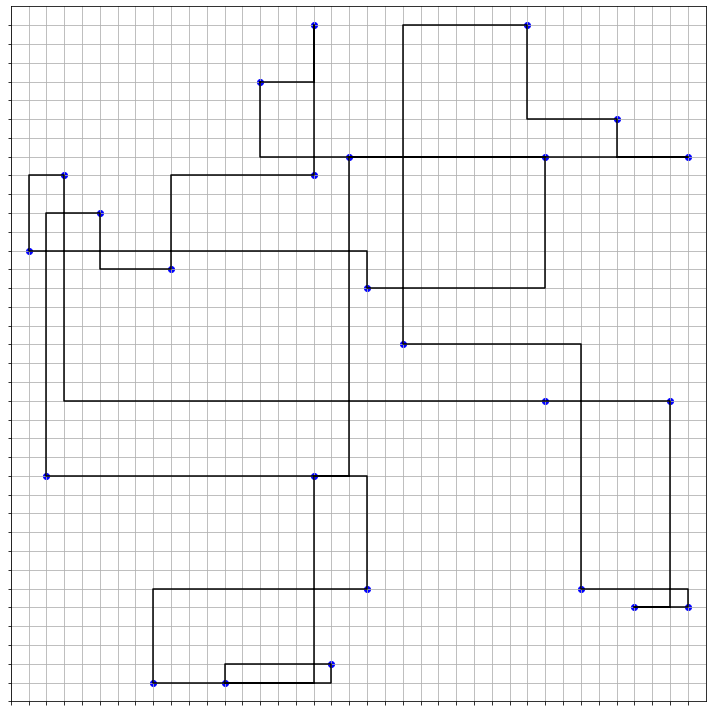

In [43]:
hc = HillClimb(10, l1_distance)
HTML(visualize_hillclimb(X, hc).to_jshtml())

### Задание 3 (4 балла)
Курьерское дело растет, теперь между городами блуждает большое количество курьеров, а их профессия вместе с известным маршрутом передается из поколение в поколение. Чем быстрее курьер способен обойти города - тем больше вероятность того, что он заработает себе на безоблачную старость и передаст свое дело потомкам. Симулируйте эволюцию курьеров, реализовав генетический алгоритм.

#### Методы
`optimize(X)` - выбирает лучшую перестановку из результатов `optimize_explain(X)`

`optimize_explain(X)` - возвращает список длины `iterations` популяций размера `population` перестановок точек `X`, полученных в процессе оптимизации. На каждом шаге алгоритм должен оставлять только `survivors` выживших, следующая популяция должна быть сгенерирована из них

In [ ]:
class Genetic:
    def __init__(self, iterations, population, survivors, distance):
        self.pop_size = population
        self.surv_size = survivors
        self.dist = distance
        self.iters = iterations
    
    def optimize(self, X):
        pass
    
    def optimize_explain(self, X):
        pass

In [ ]:
gen = Genetic(200, 100, 20, l1_distance)
HTML(visualize_genetic(X, gen).to_jshtml())